In [2]:
%matplotlib inline
from pylab import *

In [1]:
import pandas as pd

In [2]:
from tqdm import tqdm

In [3]:
import numpy as np

In [4]:
from keras.layers import merge

Using TensorFlow backend.


In [5]:
import tensorflow as tf

In [6]:
from keras.layers.core import Lambda

In [7]:
from keras.applications.resnet50 import ResNet50

In [8]:
from keras.layers import Dense

In [9]:
from keras.models import Model

In [10]:
import h5py

In [11]:
# import tensorflow as tf

In [12]:
from keras.models import model_from_json

In [13]:
import os

In [14]:
def make_parallel(model, gpu_count):
    __author__ = "kuza55"

    # https://github.com/kuza55/keras-extras/blob/master/utils/multi_gpu.py

    def get_slice(data, idx, parts):
        shape = tf.shape(data)
        size = tf.concat([shape[:1] // parts, shape[1:]], axis=0)
        stride = tf.concat([shape[:1] // parts, shape[1:] * 0], axis=0)
        start = stride * idx
        return tf.slice(data, start, size)

    outputs_all = []
    for i in range(len(model.outputs)):
        outputs_all.append([])

    # Place a copy of the model on each GPU, each getting a slice of the batch
    for i in range(gpu_count):
        with tf.device('/gpu:%d' % i):
            with tf.name_scope('tower_%d' % i) as scope:

                inputs = []
                # Slice each input into a piece for processing on this GPU
                for x in model.inputs:
                    input_shape = tuple(x.get_shape().as_list())[1:]
                    slice_n = Lambda(get_slice, output_shape=input_shape, arguments={'idx': i, 'parts': gpu_count})(x)
                    inputs.append(slice_n)

                outputs = model(inputs)

                if not isinstance(outputs, list):
                    outputs = [outputs]

                # Save all the outputs for merging back together later
                for l in range(len(outputs)):
                    outputs_all[l].append(outputs[l])

    # merge outputs on CPU
    with tf.device('/cpu:0'):
        merged = []
        if len(outputs_all) == 1:
            merged.append(merge(outputs_all[0], mode='concat', concat_axis=0, name='output'))
        else:
            for outputs in outputs_all:
                merged.append(merge(outputs, mode='concat', concat_axis=0))

        return Model(input=model.inputs, output=merged)

In [15]:
json_name = 'architecture_32_2017-06-29-04-28.json'

In [16]:
# def read_model(cross=''):
#     json_name = 'architecture_32_2017-06-29-04-28.json'
#     weight_name = 'resnet_full_2017-06-29-04-28.hd5'
#     model = model_from_json(open(os.path.join('../src/cache', json_name)).read())
#     model.load_weights(os.path.join('../src/cache', weight_name))
#     return model

In [17]:
def get_model():
    base_model = ResNet50(weights='imagenet', include_top=False, pooling='avg')
    x = base_model.output
    predictions = Dense(17, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
#     model.load_weights('../src/cache/resnet_full_2017-06-29-04-28.hdf5')
    return model

In [18]:
model = make_parallel(get_model(), 2)

/home/vladimir/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:42: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/home/vladimir/anaconda2/lib/python2.7/site-packages/keras/legacy/layers.py:458: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
/home/vladimir/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:47: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=[<tf.Tenso..., inputs=[<tf.Tenso...)`


In [19]:
model.load_weights('../src/cache/resnet_full_2017-06-29-04-28.hdf5')

In [20]:
data_path = '../data/'

In [21]:
f_test = h5py.File(os.path.join(data_path, 'test_jpg.h5'))

In [113]:
# f_test.close()

In [22]:
X_test = f_test['X']

In [23]:
file_names = f_test['file_name']

In [24]:
X_test.shape

(61191, 256, 256, 3)

In [25]:
prediction = model.predict(X_test[:61184], verbose=1, batch_size=32)

61184/61184 [==============================] - 246s   


In [119]:
61191 / 64 * 64

61184

In [26]:
test_t = np.array(X_test[61184:])

In [27]:
test_t.shape

(7, 256, 256, 3)

In [28]:
prediction_t = model.predict(np.vstack([test_t, test_t]))[:7]

In [29]:
prediction_t.shape

(7, 17)

In [30]:
prediction = np.vstack([prediction, prediction_t])

In [31]:
prediction.shape

(61191, 17)

In [32]:
prediction_int = np.round(prediction).astype(int)

In [33]:
prediction_int.shape

(61191, 17)

In [34]:
labels = pd.read_csv(os.path.join(data_path, 'train_labels.csv')).drop('image_name', 1)

In [35]:
labels.columns

Index([u'agriculture', u'artisinal_mine', u'bare_ground', u'blooming',
       u'blow_down', u'clear', u'cloudy', u'conventional_mine', u'cultivation',
       u'habitation', u'haze', u'partly_cloudy', u'primary', u'road',
       u'selective_logging', u'slash_burn', u'water'],
      dtype='object')

In [36]:
np.dot(prediction_int[0], labels.columns)

'hazeprimary'

In [37]:
t = np.array([' ' + x for x in labels.columns]).astype('object')

In [38]:
np.dot(prediction_int[0], t)

' haze primary'

In [39]:
temp = []
for i in tqdm(range(prediction_int.shape[0])):
    temp += [np.dot(prediction_int[i], t)]

100%|██████████| 61191/61191 [00:00<00:00, 405697.64it/s]


In [40]:
submission = pd.DataFrame({'image_name':np.array(file_names), 'tags': temp})

In [41]:
submission['image_name'] = submission['image_name'].str.replace('.jpg', '')
submission['tags'] = submission['tags'].str.strip()

In [42]:
submission.head()

,image_name,tags
0,test_17490,haze primary
1,test_24421,agriculture clear cultivation habitation primary
2,test_15222,clear primary
3,file_14049,clear primary
4,test_29641,clear primary


In [43]:
submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61191 entries, 0 to 61190
Data columns (total 2 columns):
image_name    61191 non-null object
tags          61191 non-null object
dtypes: object(2)
memory usage: 956.2+ KB


In [44]:
submission.to_csv('../data/2017-06-29-04-28.csv', index=False)

In [101]:
sample.head()

,image_name,tags
0,test_0,primary clear agriculture road water
1,test_1,primary clear agriculture road water
2,test_2,primary clear agriculture road water
3,test_3,primary clear agriculture road water
4,test_4,primary clear agriculture road water


In [6]:
history1 = pd.read_csv('../src/history/history_2017-06-28-22-50.csv')
history2 = pd.read_csv('../src/history/history_2017-06-29-04-28.csv')

In [7]:
history = pd.concat([history1, history2])

In [8]:
history.head()

,acc,binary_crossentropy,fbeta,loss,val_acc,val_binary_crossentropy,val_fbeta,val_loss
0,0.131719,0.164885,0.851563,0.353551,0.109437,0.159193,0.851476,0.348298
1,0.135500,0.132527,0.879907,0.283853,0.181448,0.213902,0.834345,0.429293
2,0.129438,0.125106,0.886643,0.267652,0.095356,0.176530,0.860650,0.350337
3,0.138000,0.121548,0.889956,0.259666,0.150815,0.233173,0.740559,0.559195
4,0.130469,0.116480,0.894845,0.248479,0.135993,0.128266,0.883658,0.276546


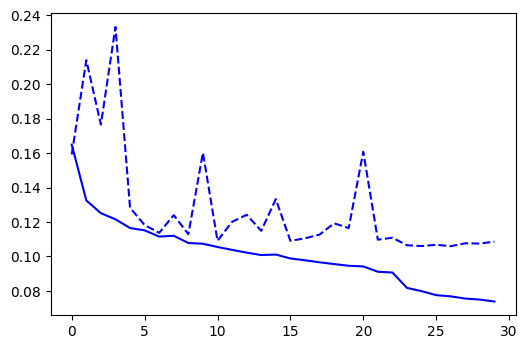

In [12]:
plot(history['binary_crossentropy'].values, 'b')
plot(history['val_binary_crossentropy'].values, 'b--')

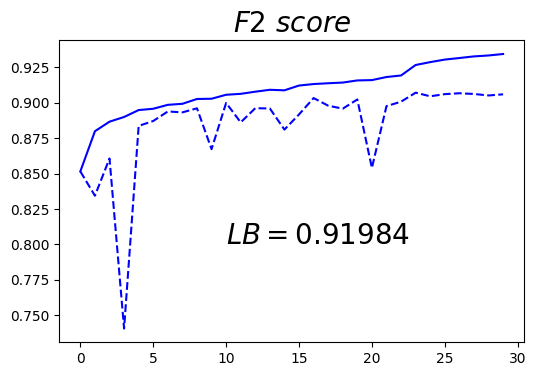

In [26]:
title('$F2$ $score$', fontsize=20)
plot(history['fbeta'].values, 'b')
plot(history['val_fbeta'].values, 'b--')
text(10, 0.8, '$LB = 0.91984$', fontsize=20)
savefig('2017-06-29-04-28.png')

(0, 0.57925360882889998)

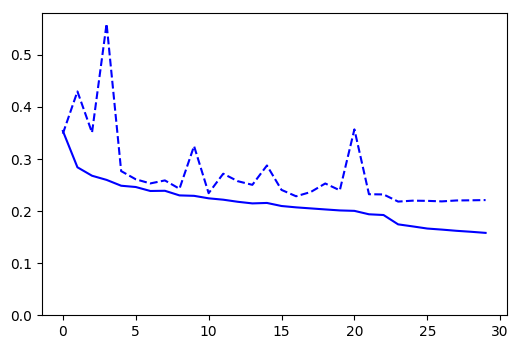

In [16]:
plot(history['loss'].values, 'b')
plot(history['val_loss'].values, 'b--')
ylim(ymin=0)